# Game of Life


The [Game of Life](http://en.wikipedia.org/wiki/Conway's_Game_of_Life) (GoF) is a cellular automaton devised by the British mathematician John Horton Conway in 1970. The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves, or, for advanced players, by creating patterns with particular properties.

The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

* Any live cell with fewer than two live neighbours dies, as if by underpopulation.
* Any live cell with more than three live neighbours dies, as if by overcrowding.
* Any live cell with two or three live neighbours lives, unchanged, to the next generation.
* Any dead cell with exactly three live neighbours becomes a live cell.

The initial pattern (generation 0) constitutes the "seed" of the system.
Time is considered discrete, and each time step (sometimes called a tick), the previous rules are applied simultaneously to every cell in the grid; "births" and "deaths" are immediate.
Each generation is a pure function of the previous generation alone.


## Assignments

* Begin by implementing the GoF's rules and create few examples with basic seeds in small dimensions. Hint: create `.gif` animations from sequences of still `.png` images
* Implement examples of the three categories of patterns *still lifes*, *oscillators* and *spaceships* (check the [wiki link](http://en.wikipedia.org/wiki/Conway's_Game_of_Life))
* Analyse the evolutions of these patterns in terms of frequency (the number of cycles required to return to the original configuration, if any), occupancy (how many alive cells there are at every step of the game), replication or heat (the average number of cells that change state at each generation), speed (if applicable), etc.
* Increase the size of the GoF's world and play with more advanced and complex patterns

In [1]:
import copy
import csv
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display, HTML

In [2]:
def display_gif(filename):
    """ Utility function to show gif images. """
    # add random parameter to the url (to overcome browser cache problems)
    n = np.random.randint(1, np.iinfo(np.int64).max, dtype=np.int64)
    display(HTML(f'''<div style="padding: 10px">
                       <img src="{filename}?{n}" style="border: 2px solid">
                     </div>'''))

# State class

The most intuitive way to represent the state of the Game of Life is by using a 2D matrix of boolean values to encode whether the cell is alive or dead. However, with this simple implementation and without any additional information, each iteration (i.e., tick) of the game would require a number of operations proportional to the number of cells in the grid to find the alive cells and apply the rules of the game.

A straightforward improvement is achieved by saving the indices $(i,j)$ of the alive cells in a list in order to directly access the alive cells in the grid to apply the rules of the game.

Since the operations performed on such a list are only of the type *add* (to revitalize a dead cell), *remove* (to kill a cell), *in* (to check if the cell is alive) and repeated elements are not allowed, a set instead of a list is highly preferred since those operations are performed in constant time on *average* (the same operations with the list are $\mathcal{O}(n)$, [source](https://wiki.python.org/moin/TimeComplexity)).

These observations motivate our implementation of the state of a game iteration: a state is represented as a set of alive cells as $(x,y)$ tuples in a given grid (not used to represent the state). 
This implementation is both time and space efficient especially if the state is sparse (few cells alive) since only the alive cells are stored.

In the following cell it is reported the class implementation of the state. Note that an ad hoc method (*get_frame()*) returns the state of the game as a PIL image of the given resolution.

In [3]:
class State:
    """ 
    Represents the state of a Game of Life iteration as
    a set of alive cells. 
    A cell is represented as a (x,y) tuple of coordinates.
    The origin is considered in the top-left corner.
    """
    
    def __init__(self, grid_size, initial_state, infinite=True):
        """
        Initialize the state with the grid dimension and
        the starting seed represented as a set of
        alive cells' coordinates.
        If infinite is True the cells can go outside the grid.
        However those cells are not shown on the image returned
        by get_frame().
        """
        self.grid_size = grid_size
        if initial_state == None:
            self.state = set()
        else:
            self.state = initial_state
        self.infinite = infinite
                
    def alive_cells(self):
        """ Returns the set of alive cells. """
        return self.state
            
    def is_alive(self, cell):
        """ Given a cell returns True if the cell is alive. """
        return cell in self.state
    
    def kill(self, cell):
        """ Kills the given cell. """
        self.state.remove(cell)
        
    def within_bounds(self, cell):
        """ Returns True if the cell is within the grid's bounds. """
        out = cell[0] >= 0 and cell[1] >= 0 and \
              cell[0] < self.grid_size[0] and   \
              cell[1] < self.grid_size[1]
        return out
    
    def revitalize(self, cell):
        """ Revitalizes the given cell if dead. """
        if (not self.infinite) and (not self.within_bounds(cell)):
            return
        self.state.add(cell)
        
    def neighbours(self, cell):
        """ Returns the 8 neighbouring cells. """
        offsets = [(x,y) for x in range(-1,2) for y in range(-1,2) if not (x == 0 and y == 0)]
        neighbours = set()
        for offset in offsets:
            neighbour = (cell[0] - offset[0], cell[1] - offset[1])
            if self.infinite or self.within_bounds(cell):
                neighbours.add(neighbour)
        return neighbours
    
    def count_alive_neighbours(self, cell):
        """ Returns the number of alive neighbours of the given cell. """
        neighbours = self.neighbours(cell)
        count = 0
        for neighbour in neighbours:
            if self.is_alive(neighbour):
                count += 1
        return count
    
    def __eq__(self, other):
        if isinstance(other, State):
            return self.state == other.state
        return False
    
    def __len__(self):
        """ Returns the number of alive cells. """
        return len(self.state)

    def get_frame(self, size):
        """ Returns the state represented as a grayscale frame of the given size. """
        frame = 255 * np.ones(self.grid_size, dtype=np.uint8)
        for cell in self.alive_cells():
            # cell is (x,y) frame has shape (rows, cols)
            #frame[cell[1], cell[0]] = 0
            if self.within_bounds(cell):
                frame[cell[1], cell[0]] = 0
        frame = Image.fromarray(frame)
        frame = frame.resize(size, resample=Image.NEAREST)
        return frame

## PatternLibrary class

PatternLibrary has been developed to be an easy way to create, store and load patterns into the game.

Our first concern was to simplify the construction of patterns. That could be a complex task if made using indeces and this could easily lead to errors. The best way to integrate some type of user interface with a notebook was to use a .csv file generated externally with a software like Excel. Below you can see an example of csv file:

| pattern_name_1 	|   	|   	|   	|
|----------------	|---	|---	|---	|
|                	| 1 	|   	|   	|
|                	|   	| 1 	|   	|
| 1              	| 1 	| 1 	|   	|
| pattern_name_2 	|   	|   	|   	|
| 1              	|   	|   	|   	|
| 1              	|   	|   	|   	|
| 1              	|   	|   	|   	|

So each new pattern should have a starting line where in the first cell cointains the pattern name. Below from the top left corner you put 1s where you have an active cell.

There are auxiliary methods to return pattern names and a single pattern giver its name.

In [4]:
class PatternLibrary:
    
    def  __init__(self, csv_filename):        
        # read the patterns
        raw_patterns = {}
        with open(csv_filename, newline='', encoding='utf-8-sig') as csvfile:
            rows = csv.reader(csvfile, delimiter=';')
            pattern_name = ''
            for row in rows:
                if row[0] not in ['', '1']:
                    pattern_name = row[0]
                    raw_patterns[pattern_name] = []
                else:
                    raw_patterns[pattern_name].append(row)
                    
        # parse the patterns
        self.patterns = {}            
        for name, pattern in raw_patterns.items():
            self.patterns[name] = set()
            for y, row in enumerate(pattern):
                for x, cell in enumerate(row):
                    if cell == '1':
                        self.patterns[name].add((x,y))
        
    def __len__(self):
        """ Returns the number of patterns in the library. """
        return len(self.patterns)
    
    def get_names(self):
        """ Returns the list of pattern names in the library. """
        return list(self.patterns.keys())
                
    def get_pattern(self, name):
        """ Returns the pattern with the given name. """
        return self.patterns[name]
    
    def to_numpy(self, name, pad=1):
        """ Returns a given pattern as a numpy array. """
        pattern = self.patterns[name]
        rows, cols = [], []
        for x, y in pattern:
            rows.append(y)
            cols.append(x)
        
        nrows = max(rows) + 1 + 2*pad
        ncols = max(cols) + 1 + 2*pad
        frame = 255 * np.ones((nrows, ncols), dtype=np.uint8)
        for cell in pattern:
            frame[cell[1]+pad, cell[0]+pad] = 0
            
        return frame

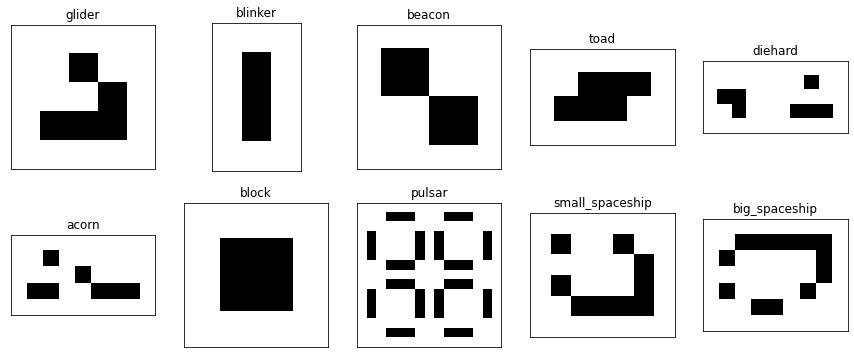

In [5]:
library = PatternLibrary('patterns.csv')
#print('Patterns in the library:', library.get_names())

patterns_names = library.get_names()
ncols = 5
nrows = int(np.ceil(len(library) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3,nrows*3))
for i, ax in enumerate(axs.flatten()):
    if i < len(library):
        ax.imshow(library.to_numpy(patterns_names[i]), cmap='gray')
        ax.set_title(patterns_names[i])
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.axis('off')

# Game class

The Game class manages the execution of a game. Notably, for the sake of optimization, a game is interrupted when the associated current state matches the previous state. It makes possible to activate the cells of a game with a certain probability and it provides methods to deal with pattern loading and visualization. Also, the metrics (period, replication, occupancy, velocity) characterizing a specific game instance are computed by means of this class' methods. In particular, the velocity is estimated based on the centers of mass of the patterns, in order to obtain values that are more robust and accurate than the ones returned by methods based on different quantities (e.g., the period).

In [6]:
class Game:
    
    def __init__(self, initial_state=None, grid_size=(64, 64)):
        self.size = grid_size
        init_state = State(grid_size, initial_state)
        self.history = [init_state]
        
    def run(self, iterations=100, no_state_change_stop=True):
        """ Run the game for the given number of iterations. """
        
        for i in range(iterations):
            
            prev_state = self.history[-1]
            curr_state = copy.deepcopy(prev_state)
            
            for cell in prev_state.alive_cells():
                
                alive_neighbours = prev_state.count_alive_neighbours(cell)
                if alive_neighbours < 2 or alive_neighbours > 3:
                    curr_state.kill(cell)
                
                neighbours = prev_state.neighbours(cell)
                for neighbour in neighbours:
                    alive_neighbours = prev_state.count_alive_neighbours(neighbour)
                    if alive_neighbours == 3:
                        curr_state.revitalize(neighbour)
                    
            # keep track of the state
            self.history.append(curr_state)
            
            if i > 0 and no_state_change_stop and prev_state == curr_state:
                break
    
    def random_initialization(self, prob=0.2):
        """ Initialize the cells of a game randomly, i.e, each cell is alive with a predetermined probability. """
        probs = np.random.uniform(size=self.size)
        probs[probs >= prob] = 0
        y, x = probs.nonzero()
        for cell in zip(x,y):
            self.history[-1].revitalize(cell)
    
    # https://pillow.readthedocs.io/en/latest/handbook/image-file-formats.html#saving-sequences
    def export_gif(self, filename, size=(256,256), frametime=200):
        """ Export the game history as an animated gif of the given resolution. """
        frames = []
        for state in self.history:
            frames.append(state.get_frame(size))            
        frames[0].save(filename, save_all=True, append_images=frames[1:], duration=frametime, loop=0)

    def load_pattern(self, pattern, pattern_pos):
        """ Load a specific pattern in the game. """
        curr_state = self.history[-1]
        for cell in pattern:
            cell = (cell[0] + pattern_pos[0], cell[1] + pattern_pos[1])
            curr_state.revitalize(cell)

    def compute_period(self):
        """ Returns the period of a pattern or 0 if the pattern does not repeat. """
        if len(self.history) < 2:
            raise Exception('It is required to run the game.')
            
        for i, state in enumerate(self.history[1:], 1):
            if state == self.history[0]:
                return i
            
        return 0

    def compute_replication(self):
        """ Returns the number of cells that change state at each tick. """
        if len(self.history) < 2:
            raise Exception('It is required to run the game.')

        replication = []

        for i in range(1, len(self.history)):
            curr_alive = self.history[i].alive_cells()
            prev_alive = self.history[i-1].alive_cells()

            death_counter = 0
            birth_counter = 0
        
            for cell in curr_alive:
                if cell not in prev_alive:
                    birth_counter += 1

            for cell in prev_alive:
                if cell not in curr_alive:
                    death_counter += 1
            
            replication.append((birth_counter, death_counter))
            
        return replication
    
    def compute_occupancy(self):
        """ Returns the number of alive cells at each tick. """
        occupancy = []
        
        for i in range(len(self.history)):
            occupancy.append(len(self.history[i]))
            
        return occupancy
    
    def compute_velocity(self):
        if len(self.history) < 2:
            raise Exception('It is required to run the game.')
            
        cms = [] # center of mass at each tick
        for state in self.history:
            x_cm, y_cm = 0, 0
            for cell in state.alive_cells():
                x_cm += cell[0]
                y_cm += cell[1]
            alive_cells = len(state.alive_cells())
            x_cm = x_cm / alive_cells if alive_cells != 0 else cms[-1][0]
            y_cm = y_cm / alive_cells if alive_cells != 0 else cms[-1][1]
            cms.append((x_cm, y_cm))
            
        cms_x = np.asarray([cm[0] for cm in cms])
        cms_y = np.asarray([cm[1] for cm in cms])
        
        v_x = cms_x[1:] - cms_x[:-1]
        v_y = cms_y[1:] - cms_y[:-1]        
        #v = np.sqrt(v_x**2+v_y**2)
        
        return v_x, v_y

Test the game:

In [7]:
blinker = library.get_pattern('blinker')
glider = library.get_pattern('glider')

game = Game(grid_size=(32,32))
game.load_pattern(blinker, (16,16))
game.load_pattern(glider, (0,0))
game.run()

path = 'outputs/test.gif'
game.export_gif(path, frametime=200)
display_gif(path)

# Pattern analysis

This function is faced to the output of the analysis of the patterns. Given a pattern, its position and the dimension of the grid as parameters, a game for this pattern is created and executed. This function defines a pipeline to avoid the repetition of the code. 
In fact, the methods to compute period, occupancy, replication and velocity are defined in the Game class. 
In particular this function returns the values of period, average occupancy, average births, average deaths and average speed. It returns also the plots of the behaviors of occupancy, replication and velocity within the number of iterations defined.

In [8]:
def analyze_pattern(pattern_library, pattern_name, grid_size, pattern_pos, iterations=10):
    
    print('Pattern:', pattern_name)
    
    pattern = pattern_library.get_pattern(pattern_name)

    game = Game(grid_size=grid_size)
    game.load_pattern(pattern, pattern_pos=pattern_pos)
    game.run(iterations, no_state_change_stop=False)

    filename = f'./outputs/{pattern_name}.gif'
    game.export_gif(filename, size=(256,256), frametime=300)
    display_gif(filename)
    
    print('Period:', game.compute_period())
      
    fig, axs = plt.subplots(3, 1, figsize=(8,12))
    
    occupancy = game.compute_occupancy()
    print(f'Average occupancy: {np.mean(occupancy):.1f} cells')
    axs[0].plot(occupancy)
    axs[0].set_title('Occupancy')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Alive cells')
    
    replications = game.compute_replication()
    births = [x[0] for x in replications]
    deaths = [x[1] for x in replications]
    print(f'Average births:    {np.mean(births):.1f} cells/tick')
    print(f'Average deaths:    {np.mean(deaths):.1f} cells/tick')
    axs[1].plot(births, label='births')
    axs[1].plot(deaths, label='deaths')
    axs[1].set_title('Replications')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Cells')
    axs[1].legend()
    
    velocity = game.compute_velocity()
    v_x = velocity[0]
    v_y = velocity[1]
    v = np.sqrt(v_x**2 + v_y**2)
    print(f'Average speed:     {np.mean(v):.2f} cells/tick')
    axs[2].plot(v)
    axs[2].set_title('Velocity')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('$v$ [cells/iter]')
    
    fig.tight_layout(pad=2)

## Still lives

These patterns do not change from one iteration to the next.

Pattern: block


Period: 1
Average occupancy: 4.0 cells
Average births:    0.0 cells/tick
Average deaths:    0.0 cells/tick
Average speed:     0.00 cells/tick


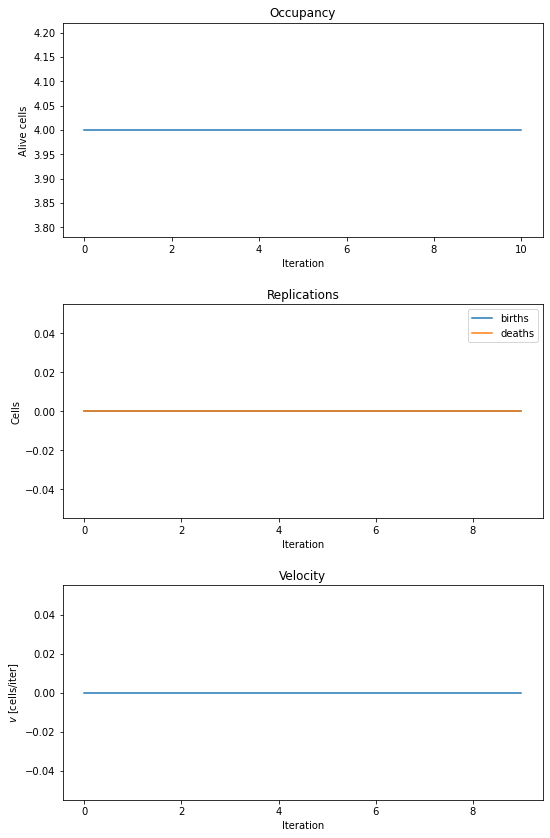

In [9]:
analyze_pattern(library, 'block', grid_size=(6,6), pattern_pos=(2,2))

## Oscillators

These patterns return to their initial state after a finite number of iterations.

Pattern: blinker


Period: 2
Average occupancy: 3.0 cells
Average births:    2.0 cells/tick
Average deaths:    2.0 cells/tick
Average speed:     0.00 cells/tick


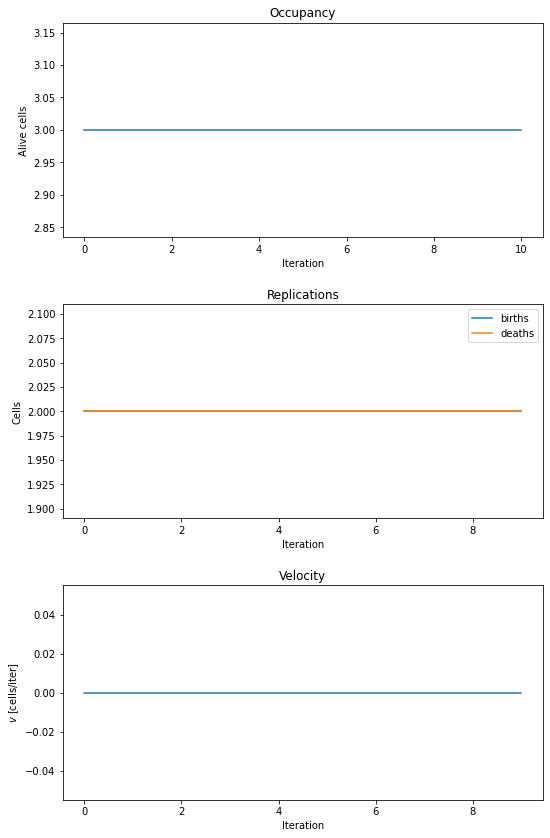

In [10]:
analyze_pattern(library, 'blinker', grid_size=(5,5), pattern_pos=(2,1))

Pattern: toad


Period: 2
Average occupancy: 6.0 cells
Average births:    4.0 cells/tick
Average deaths:    4.0 cells/tick
Average speed:     0.00 cells/tick


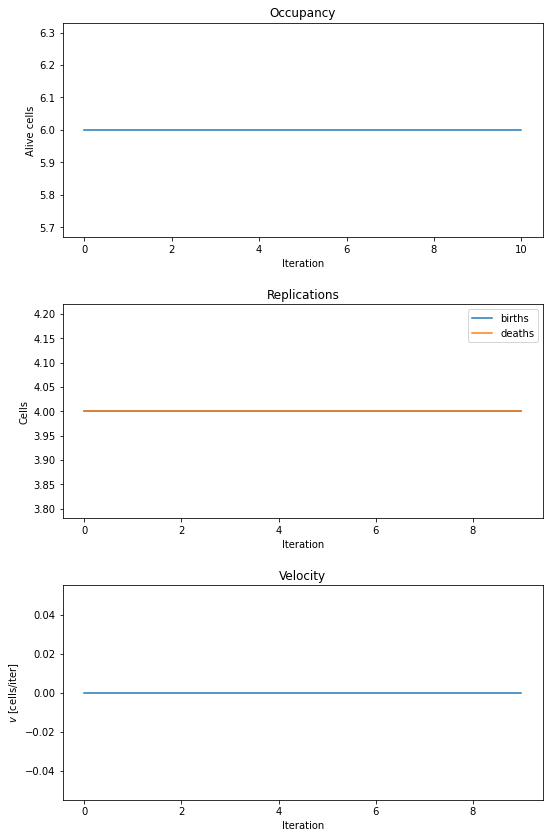

In [11]:
analyze_pattern(library, 'toad', grid_size=(6,6), pattern_pos=(1,2))

Pattern: pulsar


Period: 3
Average occupancy: 57.5 cells
Average births:    22.4 cells/tick
Average deaths:    21.6 cells/tick
Average speed:     0.00 cells/tick


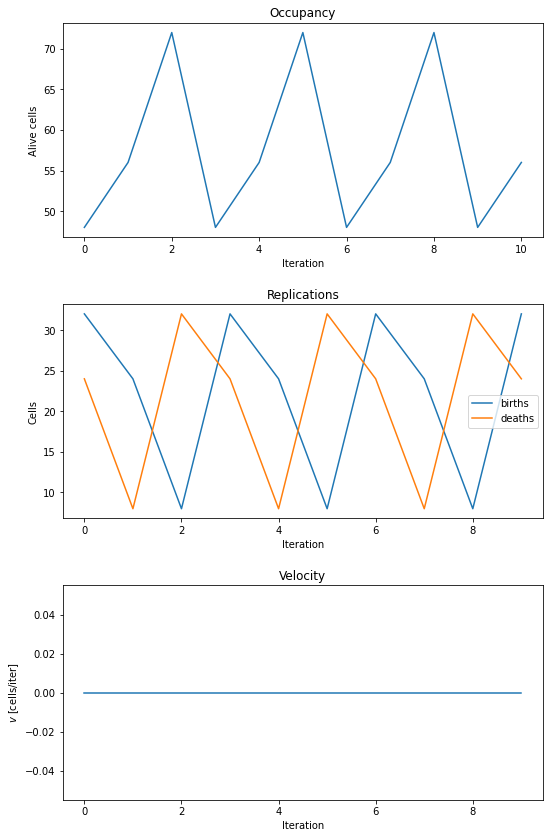

In [12]:
analyze_pattern(library, 'pulsar', grid_size=(17,17), pattern_pos=(2,2))

## Spaceships

These patterns translate themselves across the grid.

Pattern: glider


Period: 0
Average occupancy: 5.0 cells
Average births:    2.0 cells/tick
Average deaths:    2.0 cells/tick
Average speed:     0.42 cells/tick


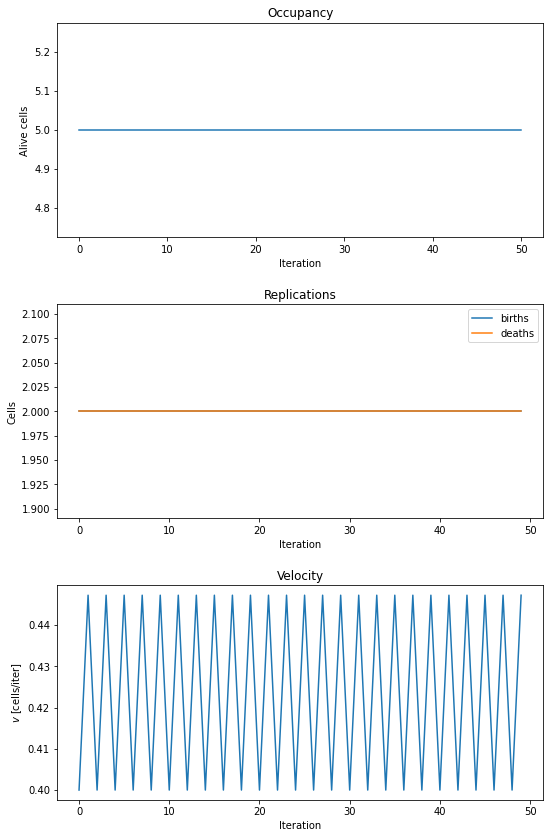

In [13]:
analyze_pattern(library, 'glider', grid_size=(16,16), pattern_pos=(0,0), iterations=50)

Pattern: small_spaceship


Period: 0
Average occupancy: 10.5 cells
Average births:    5.5 cells/tick
Average deaths:    5.5 cells/tick
Average speed:     0.71 cells/tick


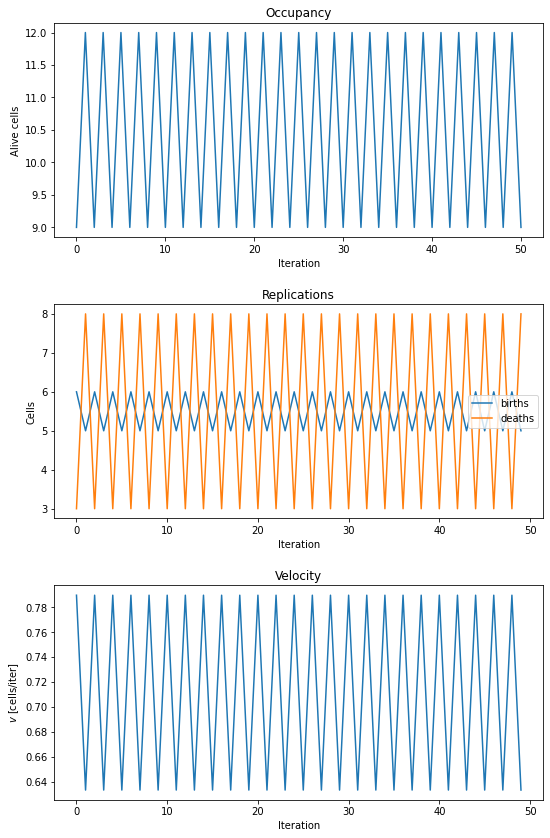

In [14]:
analyze_pattern(library, 'small_spaceship', grid_size=(32,32), pattern_pos=(0,10), iterations=50)

Pattern: big_spaceship


Period: 0
Average occupancy: 15.5 cells
Average births:    9.5 cells/tick
Average deaths:    9.5 cells/tick
Average speed:     0.86 cells/tick


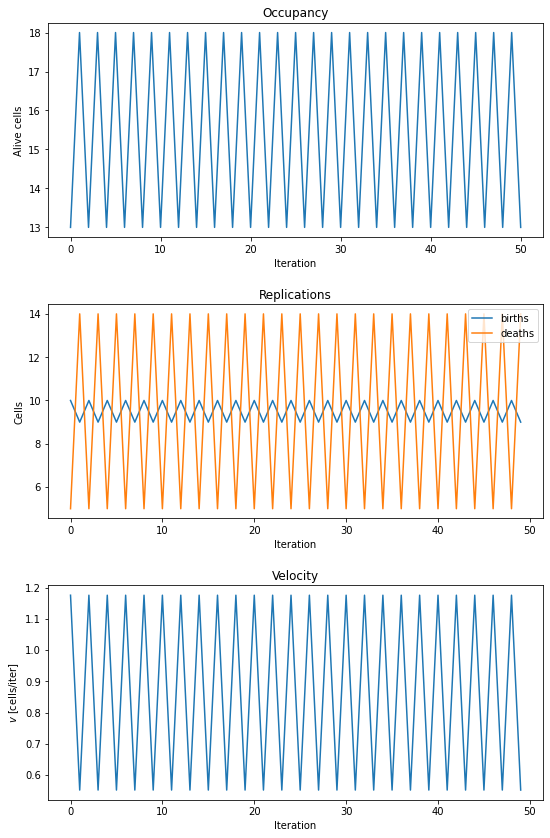

In [15]:
analyze_pattern(library, 'big_spaceship', grid_size=(32,32), pattern_pos=(0,10), iterations=50)

## Other patterns

We also decided to analyze Diehard, which is a pattern that disappears after 130 iterations.

Pattern: diehard


Period: 0
Average occupancy: 17.7 cells
Average births:    8.1 cells/tick
Average deaths:    8.1 cells/tick
Average speed:     0.48 cells/tick


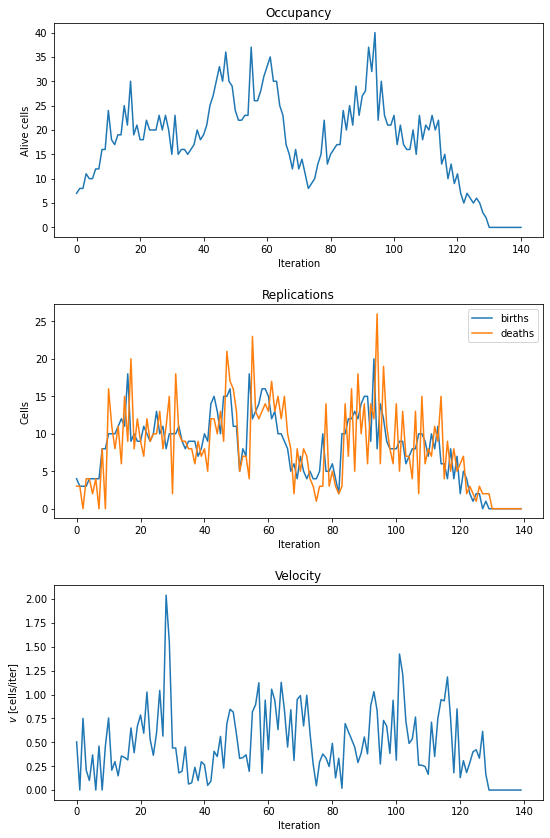

In [16]:
analyze_pattern(library, 'diehard', grid_size=(32,32), pattern_pos=(12,12), iterations=140)

# Complex patterns

To better test the functioning of the game we decided to try more complex patterns:
* The "Gosper glider gun", which produces its first glider on the 15th iteration, and another glider every 30 iterations from then on.
* The "Simkin glider gun", which releases a glider every 120 iterations.
* Two patterns that grow indefinitely.

In [17]:
complex_library = PatternLibrary('complex_patterns.csv')

In [18]:
gosper_glider_gun = complex_library.get_pattern('gosper_glider_gun')

game = Game(grid_size=(48,48))
game.load_pattern(gosper_glider_gun, (5,10))
game.run(iterations=400)

path = 'outputs/gosper_glider_gun.gif'
game.export_gif(path, frametime=100)
display_gif(path)

In [19]:
simkin_glider_gun = complex_library.get_pattern('simkin_glider_gun')

game = Game(grid_size=(48,48))
game.load_pattern(simkin_glider_gun, (5,10))
game.run()

path = 'outputs/simkin_glider_gun.gif'
game.export_gif(path, frametime=200)
display_gif(path)

In [20]:
indefinite_grow = complex_library.get_pattern('indefinite_grow')

game = Game(grid_size=(48,48))
game.load_pattern(indefinite_grow, (20,20))
game.run()

path = 'outputs/indefinite_grow.gif'
game.export_gif(path, frametime=200)
display_gif(path)

In [21]:
indefinite_grow2 = complex_library.get_pattern('indefinite_grow2')

game = Game(grid_size=(48,48))
game.load_pattern(indefinite_grow2, (10,20))
game.run()

path = 'outputs/indefinite_grow2.gif'
game.export_gif(path, frametime=200)
display_gif(path)

## Random patterns

Finally we tried the game with random patterns. In particular, after assigning a random probability to each cell of the grid, if the probabilty of a cell is lower than the probability passed as argument to the function random_initialization(), then the cell is alive.

In [22]:
game = Game(grid_size=(64,64))
game.random_initialization(.2)
game.run(300)

path = 'outputs/random.gif'
game.export_gif(path, frametime=100)
display_gif(path)

In [23]:
game = Game(grid_size=(64,64))
game.random_initialization(.8)
game.run()

path = 'outputs/random2.gif'
game.export_gif(path, frametime=500)
display_gif(path)